### This is the code to grid search the best parameters for the SARIMAX model using autoarima and the exogenous variables.
#### References: 
- Kalyvas, V. (2024, January 19). Time Series Episode 3: ARIMA predictioning with exogenous variables. Medium. https://python.plainenglish.io/time-series-episode-3-arima-forecasting-with-exogenous-variables-6658f82170e4
- Peixeiro, M. (2022). Time series forecasting in Python (Section 9). Manning. Contribution: The logic for residual analysis and the implementation of the Ljung-Box test.


#### Libraries
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html
- Smith, T. G., & Others. (2017). Package pmdarima: ARIMA estimators for Python (2.0.4) [Python]. http://www.alkaline-ml.com/pmdarima
- Package statsmodels (0.14). (2024). [Python]. statsmodels. https://github.com/statsmodels/statsmodels

In [63]:
# Import libraries

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

import useful_functions as uf

In [64]:
# load the data
file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
#file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# define the target variable as the first column
target_variable = df_raw.columns[0]
# Convert all columns to float
df_raw = df_raw.astype('float64')

# Remove outliers? Define the threshold from 0 to 1 - float
remove_outliers_threshold = np.nan
#remove_outliers_threshold = 0.20



In [65]:
# Remove outliers according to the threshold
if not pd.isna(remove_outliers_threshold):
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else:
    df_cleaned = df_raw.copy()

In [66]:
# After removing the outliers, fill the missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

# Define test and validation set sizes
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets

train_raw = df_adjusted[:-test_size] # This total trainning set will be used to train the final model
test_raw = df_adjusted[-test_size:]

In [67]:
# Let´s scale the dfs
# Define the scaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_raw) # fit and transform the train set
scaled_test = scaler.transform(test_raw) # transform the test set
# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_adjusted.columns)
test = pd.DataFrame(scaled_test, columns=df_adjusted.columns)
# Include the index in the train and test sets
train.index = df_adjusted.index[:-test_size]
test.index = df_adjusted.index[-test_size:]

# define the exogenous variables as all except the first column
exog_var_train = train.iloc[:, 1:].ffill()
exog_var_test = test.iloc[:, 1:].ffill()

In [68]:
# If you need to use the auto_arima function to find the best parameters, use the following code
# auto_model = auto_arima(train[target_variable], 
#                               start_p=0, start_q=0, 
#                               max_p=12, max_q=12, 
#                               m=12, 
#                               start_P=0, start_Q=0, 
#                               max_P=12, max_Q=12, 
#                               seasonal=True, 
#                               d=None, D=None,  
#                               trace=False,
#                               error_action='ignore',  
#                               suppress_warnings=True, 
#                               stepwise=True, 
#                               exog = exog_var_train, max_order=10)

# #Adjust the model with the best parameters and train it
# model = SARIMAX(train[target_variable], order=auto_model.order, 
#                 seasonal_order=auto_model.seasonal_order, 
#                 exog = exog_var_train)

# If you need to adjust the model with specific parameters, use the following code
model = SARIMAX(train[target_variable], order=(5,1,4), 
                seasonal_order=(2,0,0,12), 
                exog = exog_var_train)

model_fit = model.fit(disp=False, maxiter=50)

print(model_fit.summary())

g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters foun

                                      SARIMAX Results                                      
Dep. Variable:             ECO_fiscal_result_month   No. Observations:                  228
Model:             SARIMAX(5, 1, 4)x(2, 0, [], 12)   Log Likelihood                 330.873
Date:                             Mon, 15 Apr 2024   AIC                           -499.747
Time:                                     14:38:52   BIC                           -222.326
Sample:                                 01-01-2001   HQIC                          -387.803
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
ECO_inflation_month                    0.0317      0.091  

In [69]:
# Get the highest absolute coeficients with p-values from the model summary
coef = model_fit.params
p_values = model_fit.pvalues
coef_p_values = pd.concat([coef, p_values], axis=1)
coef_p_values.columns = ['coef', 'p_value']
coef_p_values = coef_p_values.sort_values(by='coef', ascending=False)
print(coef_p_values.head(10))


                                 coef       p_value
ECO_revenue                  1.296101  7.384058e-20
BUDGET_fun_9_spent_value     1.213197  5.033303e-02
EXPEC_net_public_debt_y+1    0.896050  2.779896e-01
EXPEC_DIC_y+1                0.806499  5.480206e-02
EXPEC_US$_currency_y+2       0.772471  1.726842e-01
BUDGET_fun_12_spent_value    0.738137  1.764728e-03
EXPEC_primary_result_y+2     0.691919  2.055776e-02
WD_CNY                       0.471001  3.278634e-01
EXPEC_primary_result_y+1     0.456150  2.389681e-01
EXPEC_basic_interest_rate_y  0.397524  1.446805e-01


In [70]:
coef_p_values = coef_p_values.sort_values(by='coef', ascending=True)
print(coef_p_values.head(10))

                                       coef   p_value
BUDGET_type_mandatory_spent_value -1.792377  0.050772
ECO_GDP_R$_12_months              -1.418610  0.005478
EXPEC_primary_result_y            -0.937852  0.017348
ar.L1                             -0.920443  0.080300
ar.L2                             -0.864624  0.010086
EXPEC_net_public_debt_y           -0.628063  0.229085
ar.L3                             -0.602050  0.099040
EXPEC_basic_interest_rate_y+2     -0.574288  0.090265
ma.L4                             -0.510637  0.083281
EXPEC_US$_currency_y+1            -0.432105  0.491585


In [71]:

# create predictions on training set (to evaluate how the model behaves to known-training data)
predictions_on_train_scaled = model_fit.predict()
# Predict for the test period
predictions_on_test_scaled = model_fit.forecast(steps=len(test[target_variable]), exog = exog_var_test)

In [72]:
# Let's reverse the scaling to get the real values
original_data_train = df_adjusted[:-test_size][target_variable]
original_data_test = df_adjusted[-test_size:][target_variable]
# Convert Pandas Series to NumPy arrays and reshape
predictions_on_train_scaled_np = predictions_on_train_scaled.to_numpy().reshape(-1, 1)
predictions_on_train_scaled_np = np.repeat(predictions_on_train_scaled_np,train.shape[1], axis=-1)
predictions_on_test_scaled_np = predictions_on_test_scaled.to_numpy().reshape(-1, 1)
predictions_on_test_scaled_np = np.repeat(predictions_on_test_scaled_np,test.shape[1], axis=-1)

# Inverse transform to get the real values
predictions_on_train_all = scaler.inverse_transform(predictions_on_train_scaled_np)
predictions_on_test_all = scaler.inverse_transform(predictions_on_test_scaled_np)

# Subset the predictions to get only the first column
predictions_on_train = predictions_on_train_all[:,0]
predictions_on_test = predictions_on_test_all[:,0]

# Convert to pandas dataframe and include the index
predictions_on_train_SARIMAX = pd.DataFrame(predictions_on_train, index=train.index, columns=[target_variable])
predictions_on_test_SARIMAX = pd.DataFrame(predictions_on_test, index=test.index, columns=[target_variable])


In [73]:
# print the AIC of the model
print('AIC: ' , model_fit.aic)

mape_SARIMAX_train = mean_absolute_percentage_error(original_data_train,predictions_on_train_SARIMAX)
rmse_SARIMAX_train = np.sqrt(mean_squared_error(original_data_train,predictions_on_train_SARIMAX))
mae_SARIMAX_train = mean_absolute_error(original_data_train,predictions_on_train_SARIMAX)

print("Errors on training set: ")
print('MAPE_SARIMAX:', mape_SARIMAX_train)
print('RMSE_SARIMAX:', rmse_SARIMAX_train)
print('MAE_SARIMAX:', mae_SARIMAX_train)


AIC:  -499.74684981152814
Errors on training set: 
MAPE_SARIMAX: 2.235311929004734
RMSE_SARIMAX: 5903.694830412995
MAE_SARIMAX: 4254.987442543674


In [74]:
# print the AIC of the model
print('AIC: ' , model_fit.aic)

mape_SARIMAX_test = mean_absolute_percentage_error(original_data_test,predictions_on_test_SARIMAX)
rmse_SARIMAX_test = np.sqrt(mean_squared_error(original_data_test,predictions_on_test_SARIMAX))
mae_SARIMAX_test = mean_absolute_error(original_data_test,predictions_on_test_SARIMAX)

print("Errors on test set: ")
print('MAPE_SARIMAX:', mape_SARIMAX_test)
print('RMSE_SARIMAX:', rmse_SARIMAX_test)
print('MAE_SARIMAX:', mae_SARIMAX_test)


AIC:  -499.74684981152814
Errors on test set: 
MAPE_SARIMAX: 2.7055443078084607
RMSE_SARIMAX: 82543.88964248559
MAE_SARIMAX: 52869.10496078254


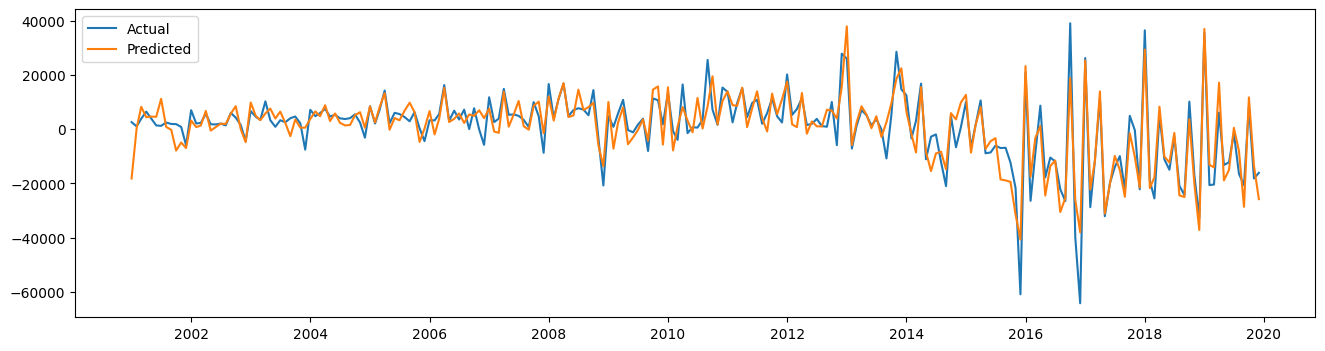

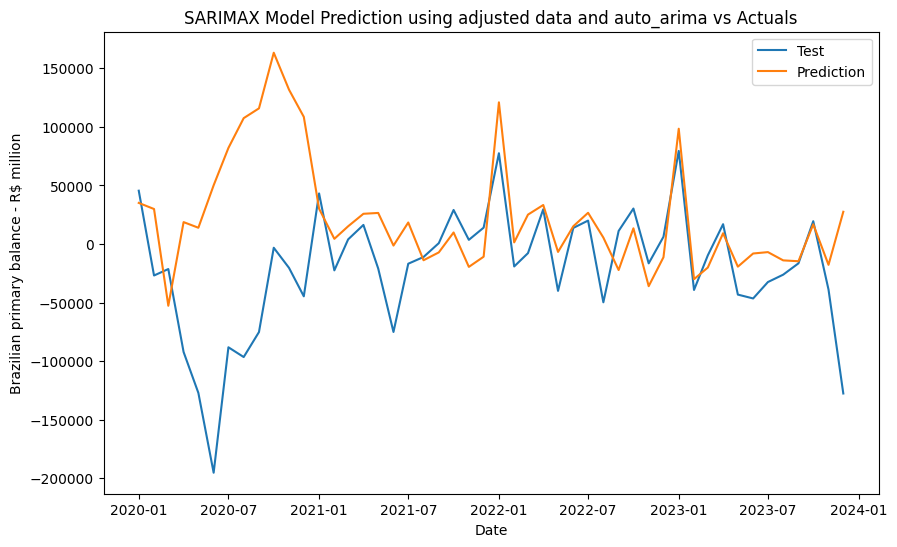

In [78]:
# plot the train and test data against their corresponding predictions

# on train data
plt.figure(figsize=(16,4))
plt.plot(original_data_train, label="Actual")
plt.plot(predictions_on_train_SARIMAX, label="Predicted")
plt.legend()

# Plot the prediction using function plot_prediction_vs_test from useful_functions
uf.plot_prediction_vs_test(
    target_variable, # Brazilian PB
    original_data_test, # Test data
    predictions_on_test_SARIMAX, # Predictions
    'SARIMAX Model Prediction using adjusted data and auto_arima vs Actuals')

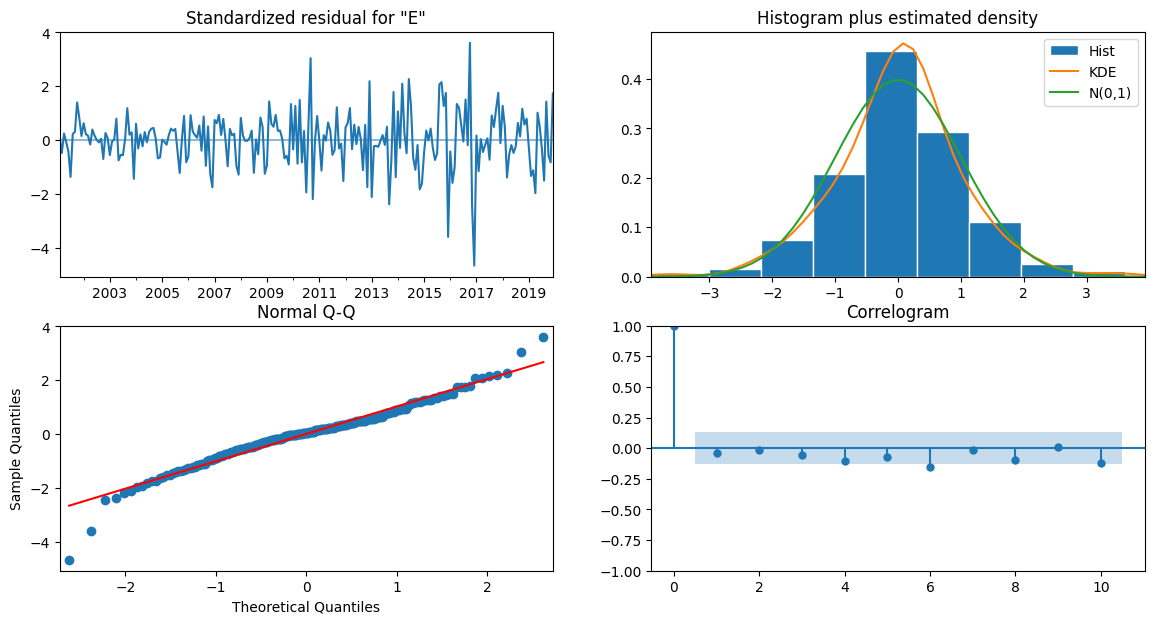

In [81]:
model_fit.plot_diagnostics(figsize=(14,7))
plt.show()

All values are above 0.05. The residuals are uncorrelated


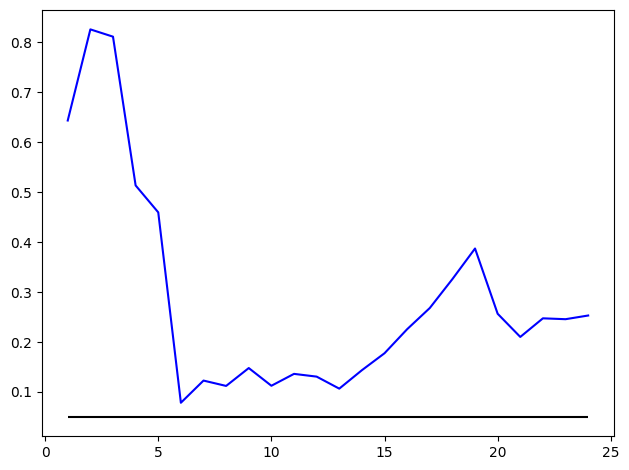

In [82]:
# Define a ljung box test method to check for autocorrelation in the residuals
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal: # If the residuals are seasonal
        lb_df = acorr_ljungbox(residuals, period=period) # Use the period =12 for monthly data
    else:
        max_lag = min([10, len(residuals)/5]) # Maximum lag to be used in the test
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black') # Threshold line at 0.05 - p-value significance level
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

# Use ljung box test to check for autocorrelation in the residuals.
residuals = model_fit.resid
# 
ljung_box_test(residuals, True, 12)